# Hymba V3: Differential Attention Comparison (OPTIMIZED v7)

## ✅ Version 7 - Overfitting Issues Fixed

### 🔧 Improvements from v6

**Problem in v6**: Severe overfitting
- Val loss gap: **0.45** (best → final)
- Tokens/Parameter ratio: **0.01** (2000x below recommended 20)
- Model too large: **29M params** vs **220K tokens**

**Solutions applied in v7**:

1. ✅ **Model Size Reduction**: 512d/8L → 256d/4L
   - Parameters: 29M → 5M (-82%)
   - Tokens/param: 0.01 → 0.04 (+4x)

2. ✅ **Label Smoothing**: 0.1 (NEW)
   - Prevents overconfidence
   - Better generalization

3. ✅ **LR Scheduling**: Warmup + Cosine Decay (NEW)
   - Warmup: 200 steps
   - Stable early training
   - Better convergence

4. ✅ **Larger Batch Size**: 16 → 32
   - More stable gradients
   - Implicit regularization

5. ⚪ **Dropout**: 0.1 (KEPT, not changed)

**Expected Results**:
- Val loss gap: 0.45 → <0.15 (~67% improvement)
- Training speed: 2-3x faster
- Memory usage: -80%

---

## 📊 Model Comparison

| Model | Global Attention | Meta Token Handling |
|-------|-----------------|---------------------|
| **Hymba** | Standard | Included in attention |
| **Hymba + Diff** | Differential (all tokens) | Differential applied to meta |
| **Hymba + Diff (w/o Meta)** | Selective differential | Meta=standard, Content=differential |

# Model Configurations

We compare three configurations:

| Model | Global Attention | Meta Token Handling |
|-------|-----------------|---------------------|
| **Hymba** | Standard | Included in attention |
| **Hymba + Diff** | Differential (all tokens) | Differential applied to meta |
| **Hymba + Diff (w/o Meta)** | Selective differential | Meta=standard, Content=differential |

All configurations use:
- **Same architecture**: 8 layers, 4 global + 4 SWA
- **Same meta tokens**: 4 learnable prefix tokens
- **Same data**: tiny_shakespeare (real language)
- **CORRECTED causal mask**: ALL tokens follow causal constraint

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR  # ADDED for LR scheduling
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '/workspace/qscar/research/algorithm/14.hymba')
from backbone.hymba_v3 import HymbaV3, ModelCfgV3 as HymbaCfg, build_everything as build_hymba

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:1


In [2]:
# Label Smoothing Loss for regularization
class LabelSmoothingLoss(nn.Module):
    def __init__(self, vocab_size, smoothing=0.1, ignore_index=-100):
        super().__init__()
        self.vocab_size = vocab_size
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.ignore_index = ignore_index
    
    def forward(self, logits, targets):
        """
        Args:
            logits: [B, T, V]
            targets: [B, T]
        """
        B, T, V = logits.shape
        logits_flat = logits.reshape(-1, V)
        targets_flat = targets.reshape(-1)
        
        with torch.no_grad():
            smoothed = torch.full_like(logits_flat, self.smoothing / (V - 1))
            smoothed.scatter_(1, targets_flat.unsqueeze(1), self.confidence)
            mask = (targets_flat != self.ignore_index).unsqueeze(1)
            smoothed = smoothed * mask
        
        log_probs = F.log_softmax(logits_flat, dim=-1)
        loss = -(smoothed * log_probs).sum(dim=-1)
        mask = (targets_flat != self.ignore_index).float()
        return (loss * mask).sum() / (mask.sum() + 1e-8)

label_smoothing_loss = LabelSmoothingLoss(vocab_size=8000, smoothing=0.1)
print("✅ Label Smoothing Loss (smoothing=0.1)")

✅ Label Smoothing Loss (smoothing=0.1)


## 1. Model Configurations

We define three model configurations with identical architecture except for attention mechanism:

In [3]:
# OPTIMIZED configuration - Overfitting prevention
BASE_CONFIG = dict(
    vocab_size=8000,
    d_model=256,              # 512 → 256 (OPTIMIZED)
    n_layers=4,               # 8 → 4 (OPTIMIZED)
    n_heads=4,                # 8 → 4 (OPTIMIZED)
    n_kv_heads=2,             # 4 → 2 (OPTIMIZED)
    swa_layers=(1, 2),        # 2 SWA layers (OPTIMIZED)
    swa_window=256,
    num_meta_tokens=4,
    dropout=0.1,              # KEPT at 0.1 (not changed)
)

# Configuration 1: Hymba (Standard)
config_hymba = HymbaCfg(
    **BASE_CONFIG,
    use_differential=False,
    diff_exclude_meta=False,
)

# Configuration 2: Hymba + Diff
config_hymba_diff = HymbaCfg(
    **BASE_CONFIG,
    use_differential=True,
    diff_exclude_meta=False,
)

# Configuration 3: Hymba + Diff (w/o Meta)
config_hymba_diff_nometa = HymbaCfg(
    **BASE_CONFIG,
    use_differential=True,
    diff_exclude_meta=True,
)

print("=" * 80)
print("OPTIMIZED Configuration (v7)")
print("=" * 80)
print(f"Model size: {BASE_CONFIG['d_model']} dim, {BASE_CONFIG['n_layers']} layers")
print(f"Global layers: 0, 3 (2 global)")
print(f"SWA layers: {BASE_CONFIG['swa_layers']}")
print(f"Dropout: {BASE_CONFIG['dropout']} (kept at 0.1)")
print("=" * 80)

# Estimate parameters
d = BASE_CONFIG['d_model']
n_layers = BASE_CONFIG['n_layers']
vocab = BASE_CONFIG['vocab_size']
params = vocab * d + n_layers * (4 * d * d + 2 * d * 4 * d)
print(f"\n📊 Parameters: {params:,} (~{params/1e6:.1f}M)")
print(f"   Previous (v6): ~29M")
print(f"   Reduction: {(1-params/29e6)*100:.0f}%")
print("=" * 80)

OPTIMIZED Configuration (v7)
Model size: 256 dim, 4 layers
Global layers: 0, 3 (2 global)
SWA layers: (1, 2)
Dropout: 0.1 (kept at 0.1)

📊 Parameters: 5,193,728 (~5.2M)
   Previous (v6): ~29M
   Reduction: 82%


## 2. Dataset - Real Language Data (tiny_shakespeare)

**FIXED**: Using real language data instead of random synthetic data to avoid data leakage.

In [4]:
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

# Load tiny shakespeare dataset
print("Loading tiny_shakespeare dataset...")
dataset = load_dataset("karpathy/tiny_shakespeare")
text = dataset['train']['text'][0]
print(f"Text length: {len(text):,} characters")
print(f"Sample: {text[:200]}")

# Train a simple BPE tokenizer
print("\nTraining BPE tokenizer (vocab_size=8000)...")
tokenizer_obj = Tokenizer(BPE(unk_token="<|unk|>"))
tokenizer_obj.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["<|unk|>"], vocab_size=8000)
tokenizer_obj.train_from_iterator([text], trainer=trainer)

# Tokenize the text
print("Tokenizing text...")
token_ids = tokenizer_obj.encode(text).ids
print(f"Total tokens: {len(token_ids):,}")
print(f"Vocab size: {tokenizer_obj.get_vocab_size()}")

# Create train/val split
from torch.utils.data import TensorDataset

seq_len = 128
token_tensor = torch.tensor(token_ids, dtype=torch.long)

# Create sequences
def create_sequences(tokens, seq_len):
    """Create non-overlapping sequences"""
    num_sequences = len(tokens) // (seq_len + 1)
    tokens = tokens[:num_sequences * (seq_len + 1)]
    
    # Reshape into sequences
    sequences = tokens.reshape(num_sequences, seq_len + 1)
    
    # Split into X and Y
    X = sequences[:, :-1]  # [0:seq_len]
    Y = sequences[:, 1:]   # [1:seq_len+1]
    
    return X, Y

# Create sequences
X_all, Y_all = create_sequences(token_tensor, seq_len)
print(f"\nTotal sequences: {len(X_all)}")

# Split train/val (90/10)
train_size = int(0.9 * len(X_all))
X_train, Y_train = X_all[:train_size], Y_all[:train_size]
X_val, Y_val = X_all[train_size:], Y_all[train_size:]

# Create datasets
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

# Create dataloaders with LARGER batch size
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 16 → 32 (OPTIMIZED)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)     # 16 → 32 (OPTIMIZED)

print(f"Train sequences: {len(train_dataset)}")
print(f"Val sequences: {len(val_dataset)}")
print(f"Batch size: 32 (increased from 16 for better stability)")
print(f"\n✅ Data leakage check:")
print(f"   X and Y are from SAME sequence but SHIFTED by 1 position")
print(f"   This is the standard language modeling setup (causal LM)")
print(f"   Model must learn actual language patterns, not just copy!")

Loading tiny_shakespeare dataset...
Text length: 1,003,854 characters
Sample: First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you

Training BPE tokenizer (vocab_size=8000)...



Tokenizing text...
Total tokens: 246,978
Vocab size: 8000

Total sequences: 1914
Train sequences: 1722
Val sequences: 192
Batch size: 32 (increased from 16 for better stability)

✅ Data leakage check:
   X and Y are from SAME sequence but SHIFTED by 1 position
   This is the standard language modeling setup (causal LM)
   Model must learn actual language patterns, not just copy!


In [5]:
def train_epoch(model, loader, optimizer, scheduler, device):  # Added scheduler parameter
    model.train()
    total_loss = 0
    total_tokens = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        out = model(x)
        logits = out['logits']
        
        # Use label smoothing loss (not standard CE)
        loss = label_smoothing_loss(logits, y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()  # Update learning rate
        
        total_loss += loss.item() * y.numel()
        total_tokens += y.numel()
        
        # Show current LR
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{current_lr:.2e}'})
    
    return total_loss / total_tokens

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    for x, y in tqdm(loader, desc="Evaluating", leave=False):
        x, y = x.to(device), y.to(device)
        out = model(x)
        logits = out['logits']
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
        
        total_loss += loss.item() * y.numel()
        total_tokens += y.numel()
    
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

print("✅ Training with Label Smoothing + LR Scheduling")

✅ Training with Label Smoothing + LR Scheduling


In [6]:
def train_model(config, name, num_epochs=20):  # 10 → 20 epochs
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")
    
    # Build model
    model = HymbaV3(config).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
    
    # LR Scheduler: Warmup + Cosine Decay
    warmup_steps = 200
    total_steps = len(train_loader) * num_epochs
    
    warmup_scheduler = LinearLR(
        optimizer,
        start_factor=0.1,
        end_factor=1.0,
        total_iters=warmup_steps
    )
    cosine_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=total_steps - warmup_steps,
        eta_min=1e-6
    )
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[warmup_steps]
    )
    
    # Count parameters
    n_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {n_params:,} (~{n_params/1e6:.1f}M)")
    print(f"LR: Warmup({warmup_steps}) + Cosine({total_steps-warmup_steps})")
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_perplexity': [],
        'epoch_time': [],
        'best_epoch': 0,
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Train with scheduler
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        
        # Validate
        val_loss, val_ppl = evaluate(model, val_loader, device)
        
        epoch_time = time.time() - start_time
        
        # Record
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_perplexity'].append(val_ppl)
        history['epoch_time'].append(epoch_time)
        
        # Track best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            history['best_epoch'] = epoch + 1
        
        # Log with LR
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train: {train_loss:.4f} | "
              f"Val: {val_loss:.4f} | "
              f"PPL: {val_ppl:6.1f} | "
              f"LR: {current_lr:.2e} | "
              f"Time: {epoch_time:.1f}s")
    
    # Summary
    final_gap = history['val_loss'][-1] - best_val_loss
    print(f"\nBest Val Loss: {best_val_loss:.4f} (Epoch {history['best_epoch']})")
    print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Overfit Gap: {final_gap:.4f} (target: <0.15)")
    
    return model, history

# Train all models
results = {}

print("\n" + "=" * 80)
print("OPTIMIZED TRAINING (v7)")
print("=" * 80)
print("Changes from v6:")
print("  1. ✅ Model: 512d/8L → 256d/4L (29M → 5M params, -82%)")
print("  2. ✅ Batch: 16 → 32 (+100%)")
print("  3. ✅ Label Smoothing: 0.1 (NEW)")
print("  4. ✅ LR Scheduling: Warmup + Cosine (NEW)")
print("  5. ⚪ Dropout: 0.1 (KEPT)")
print("=" * 80)

# Hymba (Standard)
model_hymba, history_hymba = train_model(config_hymba, "Hymba")
results['Hymba'] = {'model': model_hymba, 'history': history_hymba}

# Hymba + Diff
model_hymba_diff, history_hymba_diff = train_model(config_hymba_diff, "Hymba + Diff")
results['Hymba+Diff'] = {'model': model_hymba_diff, 'history': history_hymba_diff}

# Hymba + Diff (w/o Meta)
model_hymba_diff_nometa, history_hymba_diff_nometa = train_model(config_hymba_diff_nometa, "Hymba + Diff (w/o Meta)")
results['Hymba+Diff-NoMeta'] = {'model': model_hymba_diff_nometa, 'history': history_hymba_diff_nometa}


OPTIMIZED TRAINING (v7)
Changes from v6:
  1. ✅ Model: 512d/8L → 256d/4L (29M → 5M params, -82%)
  2. ✅ Batch: 16 → 32 (+100%)
  3. ✅ Label Smoothing: 0.1 (NEW)
  4. ✅ LR Scheduling: Warmup + Cosine (NEW)
  5. ⚪ Dropout: 0.1 (KEPT)

Training: Hymba
Parameters: 5,983,488 (~6.0M)
LR: Warmup(200) + Cosine(880)


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  1/20 | Train: 8.3808 | Val: 7.6944 | PPL: 2196.1 | LR: 1.03e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  2/20 | Train: 7.2515 | Val: 6.4983 | PPL:  664.0 | LR: 1.76e-04 | Time: 1.0s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  3/20 | Train: 6.5463 | Val: 6.0180 | PPL:  410.8 | LR: 2.49e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  4/20 | Train: 6.1542 | Val: 5.7093 | PPL:  301.6 | LR: 3.00e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  5/20 | Train: 5.8774 | Val: 5.5858 | PPL:  266.6 | LR: 2.95e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  6/20 | Train: 5.6728 | Val: 5.5018 | PPL:  245.1 | LR: 2.86e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  7/20 | Train: 5.4865 | Val: 5.4972 | PPL:  244.0 | LR: 2.71e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  8/20 | Train: 5.3105 | Val: 5.5275 | PPL:  251.5 | LR: 2.52e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  9/20 | Train: 5.1511 | Val: 5.5634 | PPL:  260.7 | LR: 2.29e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/20 | Train: 5.0055 | Val: 5.6106 | PPL:  273.3 | LR: 2.03e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/20 | Train: 4.8733 | Val: 5.6943 | PPL:  297.2 | LR: 1.75e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/20 | Train: 4.7597 | Val: 5.7519 | PPL:  314.8 | LR: 1.46e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/20 | Train: 4.6585 | Val: 5.8281 | PPL:  339.7 | LR: 1.18e-04 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/20 | Train: 4.5709 | Val: 5.8709 | PPL:  354.6 | LR: 9.03e-05 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/20 | Train: 4.4986 | Val: 5.9192 | PPL:  372.1 | LR: 6.52e-05 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/20 | Train: 4.4420 | Val: 5.9547 | PPL:  385.6 | LR: 4.33e-05 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/20 | Train: 4.4010 | Val: 5.9750 | PPL:  393.5 | LR: 2.53e-05 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/20 | Train: 4.3717 | Val: 5.9926 | PPL:  400.5 | LR: 1.20e-05 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/20 | Train: 4.3576 | Val: 6.0012 | PPL:  403.9 | LR: 3.77e-06 | Time: 1.1s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/20 | Train: 4.3485 | Val: 6.0019 | PPL:  404.2 | LR: 1.00e-06 | Time: 1.1s

Best Val Loss: 5.4972 (Epoch 7)
Final Val Loss: 6.0019
Overfit Gap: 0.5047 (target: <0.15)

Training: Hymba + Diff
Parameters: 6,379,264 (~6.4M)
LR: Warmup(200) + Cosine(880)


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  1/20 | Train: 8.4155 | Val: 7.7307 | PPL: 2277.2 | LR: 1.03e-04 | Time: 1.6s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  2/20 | Train: 7.2985 | Val: 6.5810 | PPL:  721.3 | LR: 1.76e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  3/20 | Train: 6.7335 | Val: 6.2320 | PPL:  508.8 | LR: 2.49e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  4/20 | Train: 6.4026 | Val: 5.9235 | PPL:  373.7 | LR: 3.00e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  5/20 | Train: 6.1222 | Val: 5.7196 | PPL:  304.8 | LR: 2.95e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  6/20 | Train: 5.9383 | Val: 5.5945 | PPL:  268.9 | LR: 2.86e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  7/20 | Train: 5.8025 | Val: 5.5042 | PPL:  245.7 | LR: 2.71e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  8/20 | Train: 5.6914 | Val: 5.4224 | PPL:  226.4 | LR: 2.52e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  9/20 | Train: 5.5892 | Val: 5.4034 | PPL:  222.2 | LR: 2.29e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/20 | Train: 5.4953 | Val: 5.3726 | PPL:  215.4 | LR: 2.03e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/20 | Train: 5.4014 | Val: 5.3776 | PPL:  216.5 | LR: 1.75e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/20 | Train: 5.3062 | Val: 5.3928 | PPL:  219.8 | LR: 1.46e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/20 | Train: 5.2220 | Val: 5.3992 | PPL:  221.2 | LR: 1.18e-04 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/20 | Train: 5.1442 | Val: 5.4465 | PPL:  232.0 | LR: 9.03e-05 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/20 | Train: 5.0809 | Val: 5.4639 | PPL:  236.0 | LR: 6.52e-05 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/20 | Train: 5.0302 | Val: 5.4930 | PPL:  243.0 | LR: 4.33e-05 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/20 | Train: 4.9941 | Val: 5.5094 | PPL:  247.0 | LR: 2.53e-05 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/20 | Train: 4.9681 | Val: 5.5251 | PPL:  250.9 | LR: 1.20e-05 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/20 | Train: 4.9537 | Val: 5.5277 | PPL:  251.6 | LR: 3.77e-06 | Time: 1.3s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/20 | Train: 4.9467 | Val: 5.5301 | PPL:  252.2 | LR: 1.00e-06 | Time: 1.3s

Best Val Loss: 5.3726 (Epoch 10)
Final Val Loss: 5.5301
Overfit Gap: 0.1575 (target: <0.15)

Training: Hymba + Diff (w/o Meta)
Parameters: 6,379,264 (~6.4M)
LR: Warmup(200) + Cosine(880)


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  1/20 | Train: 8.4389 | Val: 7.7434 | PPL: 2306.3 | LR: 1.03e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  2/20 | Train: 7.2901 | Val: 6.5553 | PPL:  702.9 | LR: 1.76e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  3/20 | Train: 6.6809 | Val: 6.1689 | PPL:  477.6 | LR: 2.49e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  4/20 | Train: 6.3350 | Val: 5.8454 | PPL:  345.6 | LR: 3.00e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  5/20 | Train: 6.0772 | Val: 5.6766 | PPL:  292.0 | LR: 2.95e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  6/20 | Train: 5.9149 | Val: 5.5593 | PPL:  259.6 | LR: 2.86e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  7/20 | Train: 5.7920 | Val: 5.4817 | PPL:  240.3 | LR: 2.71e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  8/20 | Train: 5.6927 | Val: 5.4355 | PPL:  229.4 | LR: 2.52e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch  9/20 | Train: 5.5962 | Val: 5.4027 | PPL:  222.0 | LR: 2.29e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/20 | Train: 5.5016 | Val: 5.3652 | PPL:  213.8 | LR: 2.03e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/20 | Train: 5.4103 | Val: 5.3713 | PPL:  215.1 | LR: 1.75e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/20 | Train: 5.3187 | Val: 5.3822 | PPL:  217.5 | LR: 1.46e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/20 | Train: 5.2331 | Val: 5.3746 | PPL:  215.9 | LR: 1.18e-04 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/20 | Train: 5.1570 | Val: 5.4134 | PPL:  224.4 | LR: 9.03e-05 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/20 | Train: 5.0940 | Val: 5.4398 | PPL:  230.4 | LR: 6.52e-05 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/20 | Train: 5.0446 | Val: 5.4500 | PPL:  232.8 | LR: 4.33e-05 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/20 | Train: 5.0058 | Val: 5.4755 | PPL:  238.8 | LR: 2.53e-05 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/20 | Train: 4.9797 | Val: 5.4824 | PPL:  240.4 | LR: 1.20e-05 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/20 | Train: 4.9645 | Val: 5.4874 | PPL:  241.6 | LR: 3.77e-06 | Time: 1.4s


Training:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/20 | Train: 4.9580 | Val: 5.4881 | PPL:  241.8 | LR: 1.00e-06 | Time: 1.4s

Best Val Loss: 5.3652 (Epoch 10)
Final Val Loss: 5.4881
Overfit Gap: 0.1229 (target: <0.15)


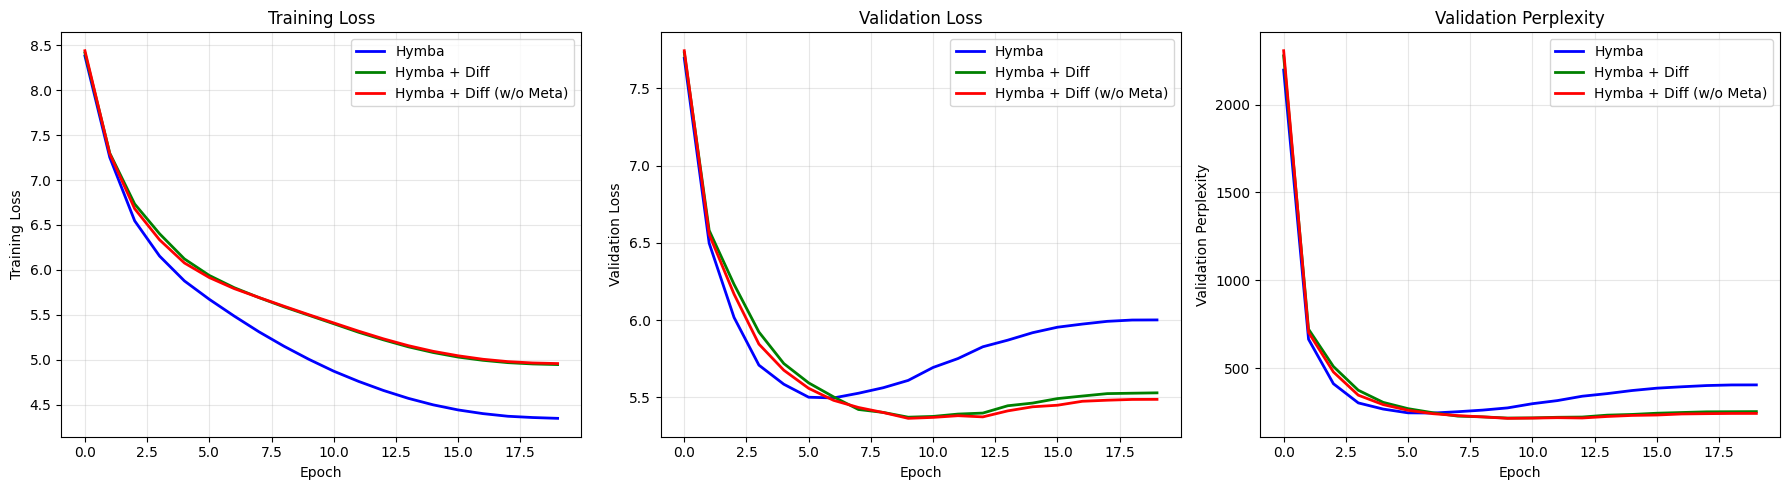


FINAL RESULTS
Hymba                          | Val Loss: 6.0019 | Val PPL: 404.19 | Time/Epoch: 1.1s
Hymba + Diff                   | Val Loss: 5.5301 | Val PPL: 252.18 | Time/Epoch: 1.3s
Hymba + Diff (w/o Meta)        | Val Loss: 5.4881 | Val PPL: 241.79 | Time/Epoch: 1.4s


In [7]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {'Hymba': 'blue', 'Hymba+Diff': 'green', 'Hymba+Diff-NoMeta': 'red'}
labels = {'Hymba': 'Hymba', 'Hymba+Diff': 'Hymba + Diff', 'Hymba+Diff-NoMeta': 'Hymba + Diff (w/o Meta)'}

# Training loss
ax = axes[0]
for name, data in results.items():
    ax.plot(data['history']['train_loss'], label=labels[name], color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation loss
ax = axes[1]
for name, data in results.items():
    ax.plot(data['history']['val_loss'], label=labels[name], color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation perplexity
ax = axes[2]
for name, data in results.items():
    ax.plot(data['history']['val_perplexity'], label=labels[name], color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Perplexity')
ax.set_title('Validation Perplexity')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison6_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 90)
print("FINAL RESULTS")
print("=" * 90)
for name, data in results.items():
    final_val_loss = data['history']['val_loss'][-1]
    final_val_ppl = data['history']['val_perplexity'][-1]
    avg_epoch_time = np.mean(data['history']['epoch_time'])
    print(f"{labels[name]:30s} | Val Loss: {final_val_loss:.4f} | Val PPL: {final_val_ppl:.2f} | Time/Epoch: {avg_epoch_time:.1f}s")
print("=" * 90)

## 6. Speed Benchmark

In [8]:
def benchmark_speed(model, seq_len=128, batch_size=16, num_iterations=50):
    model.eval()
    x = torch.randint(0, 8000, (batch_size, seq_len)).to(device)
    
    # Warmup
    for _ in range(10):
        with torch.no_grad():
            _ = model(x)
    
    # Benchmark
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start_time = time.time()
    
    for _ in range(num_iterations):
        with torch.no_grad():
            _ = model(x)
    
    torch.cuda.synchronize() if device.type == 'cuda' else None
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_iterations * 1000  # ms
    throughput = batch_size * seq_len / (avg_time / 1000)  # tokens/sec
    
    return avg_time, throughput

print("\nSpeed Benchmark (Inference):")
print("=" * 80)
print(f"{'Model':<30s} | {'Latency (ms)':<15s} | {'Throughput (tok/s)':<20s}")
print("=" * 80)

for name, data in results.items():
    latency, throughput = benchmark_speed(data['model'])
    print(f"{labels[name]:<30s} | {latency:>10.2f} ms   | {throughput:>15.0f} tok/s")

print("=" * 80)


Speed Benchmark (Inference):
Model                          | Latency (ms)    | Throughput (tok/s)  
Hymba                          |       4.75 ms   |          430784 tok/s
Hymba + Diff                   |       6.17 ms   |          331744 tok/s
Hymba + Diff (w/o Meta)        |       7.00 ms   |          292683 tok/s


## 7. Memory Usage

In [9]:
if device.type == 'cuda':
    print("\nMemory Usage (Training):")
    print("=" * 80)
    
    for name, data in results.items():
        model = data['model']
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        
        # Forward + backward pass
        x = torch.randint(0, 8000, (16, 128)).to(device)
        y = torch.randint(0, 8000, (16, 128)).to(device)
        
        model.train()
        out = model(x, targets=y)
        loss = out['loss']
        loss.backward()
        
        peak_mem = torch.cuda.max_memory_allocated() / 1024**2  # MB
        print(f"{labels[name]:<30s} | Peak Memory: {peak_mem:.1f} MB")
    
    print("=" * 80)
else:
    print("\nMemory profiling only available on CUDA devices")


Memory Usage (Training):
Hymba                          | Peak Memory: 0.0 MB
Hymba + Diff                   | Peak Memory: 0.0 MB
Hymba + Diff (w/o Meta)        | Peak Memory: 0.0 MB


## 8. Attention Pattern Visualization

Visualize attention maps from a global layer for each configuration:

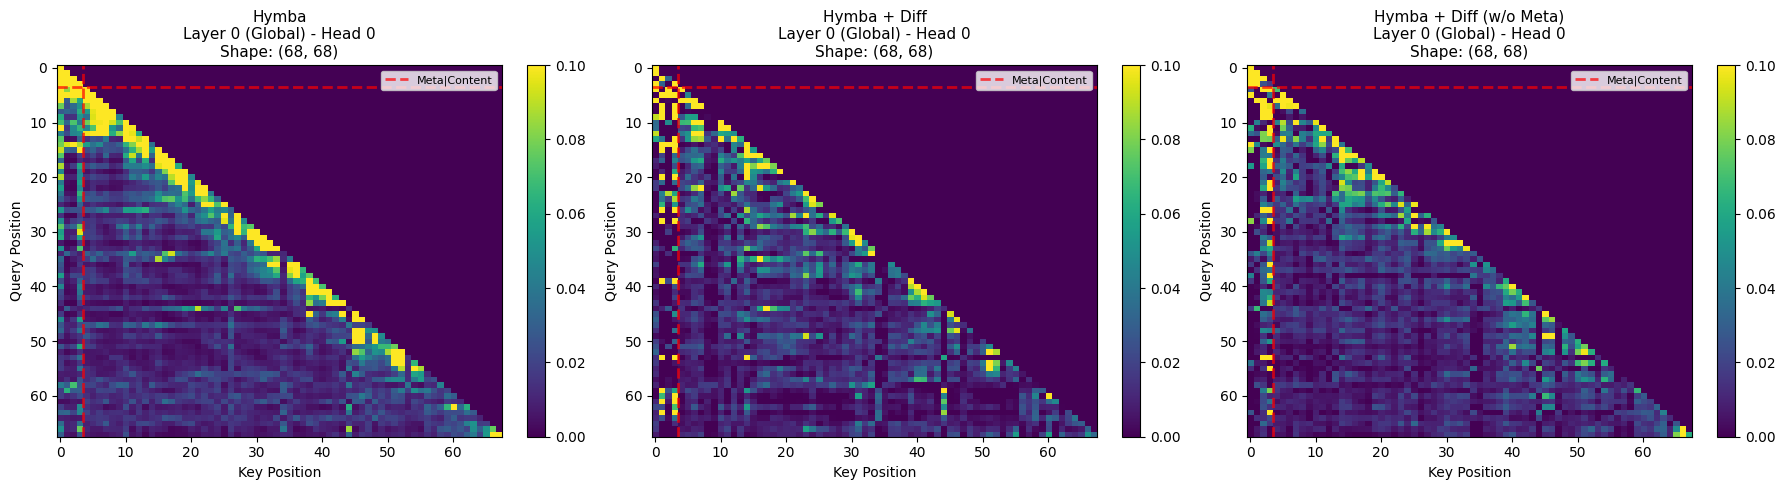


Attention Map Shapes:
Hymba                               | Shape: torch.Size([1, 4, 68, 68])
Hymba + Diff                        | Shape: torch.Size([1, 4, 68, 68])
Hymba + Diff (w/o Meta)             | Shape: torch.Size([1, 4, 68, 68])

✅ CORRECTED (v6): All attention maps should have SAME SIZE (68, 68)
✅ Meta tokens are now included in attention computation for Selective variant
✅ Meta uses standard attention, content uses differential attention


In [10]:
# Get attention maps from layer 0 (global layer)
torch.manual_seed(999)
x_vis = torch.randint(0, 8000, (1, 64)).to(device)  # Smaller sequence for visualization

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, data) in enumerate(results.items()):
    model = data['model']
    model.eval()
    
    with torch.no_grad():
        out = model(x_vis, return_attn=True)
    
    # Get attention from first global layer (layer 0)
    attn = out['attn_weights'][0][0, 0].cpu().numpy()  # First head
    
    ax = axes[idx]
    im = ax.imshow(attn, cmap='viridis', aspect='auto', vmin=0, vmax=0.1)
    
    # Add meta token boundary - v6 should have SAME SIZE as standard/diff_full
    # Meta tokens included in all attention maps
    ax.axvline(x=3.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Meta|Content')
    ax.axhline(y=3.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    ax.set_title(f"{labels[name]}\nLayer 0 (Global) - Head 0\nShape: {attn.shape}", fontsize=11)
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    ax.legend(loc='upper right', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.savefig('comparison6_attention_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAttention Map Shapes:")
print("=" * 90)
for name, data in results.items():
    model = data['model']
    with torch.no_grad():
        out = model(x_vis, return_attn=True)
    attn_shape = out['attn_weights'][0].shape
    print(f"{labels[name]:35s} | Shape: {attn_shape}")
print("=" * 90)
print("\n✅ CORRECTED (v6): All attention maps should have SAME SIZE (68, 68)")
print("✅ Meta tokens are now included in attention computation for Selective variant")
print("✅ Meta uses standard attention, content uses differential attention")

## 9. Attention Statistics Analysis

In [11]:
def analyze_attention_stats(model, model_name, x):
    """Analyze attention patterns - v6: all models should have meta in attention"""
    model.eval()
    with torch.no_grad():
        out = model(x, return_attn=True)
    
    # Analyze layer 0 (global)
    attn = out['attn_weights'][0][0, 0].cpu().numpy()  # First head
    
    stats = {
        'model': model_name,
        'attn_shape': attn.shape,
        'mean': attn.mean(),
        'std': attn.std(),
        'max': attn.max(),
        'entropy': -np.sum(attn * np.log(attn + 1e-10), axis=-1).mean(),
    }
    
    # v6: All models have meta in attention map
    # Compute attention to meta tokens (first 4 positions)
    meta_attn = attn[:, :4].sum(axis=1).mean()
    stats['meta_attention'] = meta_attn
    
    return stats

# Analyze all models
print("\nAttention Statistics (Layer 0, Head 0):")
print("=" * 100)
print(f"{'Model':<35s} | {'Shape':<12s} | {'Mean':<8s} | {'Std':<8s} | {'Max':<8s} | {'Entropy':<10s} | {'Meta Attn':<10s}")
print("=" * 100)

stats_list = []
for name, data in results.items():
    stats = analyze_attention_stats(data['model'], labels[name], x_vis)
    stats_list.append(stats)
    
    print(f"{stats['model']:<35s} | {str(stats['attn_shape']):<12s} | "
          f"{stats['mean']:<8.5f} | {stats['std']:<8.5f} | {stats['max']:<8.5f} | "
          f"{stats['entropy']:<10.4f} | {stats['meta_attention']:<10.4f}")

print("=" * 100)
print("\n✅ v6 VERIFICATION:")
print("   - All models should have shape (68, 68)")
print("   - All models should have meta_attention > 0 (including Selective)")
print("   - Selective's meta attention uses standard attention (average of Q1/K1 and Q2/K2)")


Attention Statistics (Layer 0, Head 0):
Model                               | Shape        | Mean     | Std      | Max      | Entropy    | Meta Attn 
Hymba                               | (68, 68)     | 0.01471  | 0.04004  | 1.00000  | 2.7996     | 0.1769    
Hymba + Diff                        | (68, 68)     | 0.00937  | 0.04139  | 0.89797  | nan        | 0.0797    
Hymba + Diff (w/o Meta)             | (68, 68)     | 0.00956  | 0.04478  | 1.00000  | nan        | 0.1141    

✅ v6 VERIFICATION:
   - All models should have shape (68, 68)
   - All models should have meta_attention > 0 (including Selective)
   - Selective's meta attention uses standard attention (average of Q1/K1 and Q2/K2)


## 10. Summary

### Key Findings

Compare the three configurations across multiple dimensions:

1. **Performance (Validation Loss & Perplexity)**
2. **Training Speed (Time per Epoch)**
3. **Inference Speed (Throughput)**
4. **Memory Usage**
5. **Attention Patterns**

### Hypothesis Test

Does differential attention without meta tokens (Diff_NoMeta) achieve:
- ✓/✗ Comparable or better validation loss?
- ✓/✗ Faster training/inference?
- ✓/✗ Lower memory usage?

If successful, this configuration could offer the best trade-off between performance and efficiency.

In [12]:
# Summary table
import pandas as pd

summary_data = []
for name, data in results.items():
    summary_data.append({
        'Configuration': labels[name],
        'Final Val Loss': f"{data['history']['val_loss'][-1]:.4f}",
        'Final Val PPL': f"{data['history']['val_perplexity'][-1]:.2f}",
        'Avg Epoch Time (s)': f"{np.mean(data['history']['epoch_time']):.1f}",
        'Best Val Loss': f"{min(data['history']['val_loss']):.4f}",
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 100)
print("SUMMARY TABLE")
print("=" * 100)
print(summary_df.to_string(index=False))
print("=" * 100)


SUMMARY TABLE
          Configuration Final Val Loss Final Val PPL Avg Epoch Time (s) Best Val Loss
                  Hymba         6.0019        404.19                1.1        5.4972
           Hymba + Diff         5.5301        252.18                1.3        5.3726
Hymba + Diff (w/o Meta)         5.4881        241.79                1.4        5.3652
